<a href="https://colab.research.google.com/github/ACTCollaboration/DR6_Notebooks/blob/main/ACT_DR6_detector_glitch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Glitch Cuts, Classifying Glitches, and Amplitude Fitting

*Written by Simran Nerval, Erika Hornecker, Yilun Guan, and the ACT collaboration*

---

This notebook will demonstrate how we generate glitch cuts, classify them as a point source, point source with another coincident glitch, cosmic ray, or electronic glitch, and how to estimate the amplitude of the identified sources.

In the ACT survey, the data timestreams of all detectors are packaged into files known as "time-ordered data streams" (TODs), each containing roughly 11 minutes worth of data. Using knowledge of the telescope pointing, which is recorded during data collection, the TODs are later processed into microwave sky maps using maximum likelihood map-making. The mapmaker is specifically vulnerable to biases from short, high-amplitude, non-Gaussian data bursts in the TOD, and therefore depends on these bursts being excised from the TOD before map-making. Such transient events can be caused by sporadic pathologies from the electronic readout system, cosmic rays, electromagnetic interference, radio frequency interference modulated by telescope motion, ionizing radiation, digitization artifacts, etc. Cosmic rays, for example, sometimes produce rapid spikes in the TODs of single detectors and may sometimes also warm up a region of the detector polarization array (PA) near the impact, thereby inducing a signal spike in multiple detectors. We refer to all of these transient phenomena as "glitches".

Bright astrophysical point sources can also cause high-amplitude, non-Gaussian spikes in the TOD and may be mistaken for a glitch. This may be avoided if the coordinate of the source is known before pre-processing. However, this also means that any point source or astrophysical transient that is not already known in advance of map-making can be removed from the data set entirely. It is therefore imperative when pre-processing TODs from CMB telescopes to excise as many glitches as possible while still retaining as many true astrophysical transients as feasible. In this notebook we will show you how to identify and remove glitches, classify glitches to find astrophysical sources, and how to measure the amplitude variations of these sources over the TOD.

The work in this notebook relies on a [light version](https://github.com/guanyilun/moby2_light/tree/main) of the [moby2 software](https://phy-act1.princeton.edu/public/software/moby2/) and is based on the work presented in [Nerval, Hornecker, and Guan et al. (2025)](https://arxiv.org/abs/2503.10798). The glitch cuts portion was used in ACT DR6 whereas the glitch classification and amplitude fitting sections were developed using ACT DR4 and DR6 for upcoming observatories such as SO.

**Install a light version of the TOD processing package.**

First, we need to install numpy<2 for dependency compatibility. But colab comes shipped with numpy 2. To get around this, we install numpy<2, but then you MUST click 'Runtime -> Restart Session' before proceeding. We add an assert statement to make sure this succeeded.

In [1]:
!pip install 'numpy<2'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 925.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 29.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [1]:
import numpy as np
assert np.__version__[0] == '1', f'need numpy 1, got numpy {np.__version__[0]}'

This line installs the `moby2_light` Python package, a simplified version of the full `moby2` software suite developed for CMB data analysis. `moby2_light` contains pure python re-implementation of ACT data structure for working with ACT TODs, data cuts, etc. made specifically for this notebook to illustrate the core concepts.

In [2]:
!pip install -U --force-reinstall git+https://github.com/guanyilun/moby2_light.git

  Cloning https://github.com/guanyilun/moby2_light.git to /tmp/pip-req-build-xldo9oal
  Running command git clone --filter=blob:none --quiet https://github.com/guanyilun/moby2_light.git /tmp/pip-req-build-xldo9oal
  Resolved https://github.com/guanyilun/moby2_light.git to commit 923a49f8d4837cc43fea36cc9219e2f231172eec
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 20.0 MB/s eta 0:00:00
  Created wheel for moby2: filename=moby2-0.1.0-py3-none-any.whl size=18839 sha256=ac63381814d857dbd43621d174bf4a97f02d69b43cc828fc39d08a06ddd86d4c
  Stored in directory: /tmp/pip-ephem-whe

We now will download the data, this will take a few minutes!

In [3]:
%%capture
!wget -r -np -nH --cut-dirs 3 -R "index.html*" https://phy-act1.princeton.edu/public/data/dr6_tod_v1/

**Load the necessary packages**

In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm, patches

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from moby2.tod import TOD, remove_mean, detrend_tod
from moby2.tod.cuts import *
from moby2.tod.glitch import *
import moby2.tod.statistics as stat
import moby2.tod.plotting as mplt
from moby2.tod.glitch import affected_snippets_from_cv
import moby2.tod.amplitude as amp_func

import scipy as sp
from scipy.optimize import curve_fit
%matplotlib inline

In [5]:
dir='.'

ACT collects data in units of 10 minutes. Each of these data files is called a TOD. First we will load a TOD.

In [6]:
tod_name = '1619094940.1619105593.ar5_f090'

The name stands for the starting ctime and the ending ctime of the data collection. The postfix `.ar5` refers to the detector array that this data file belongs to. To load a TOD,

In [7]:
#loads the first 6 minutes of the TOD for memory reasons in colab
tod = TOD.from_npz(dir, tod_name)

The actual detector data is stored in variable `tod.data` with shape (num of detector, num of time samples). For example, to view the entire timestream collected by detector 1759, we can do the following

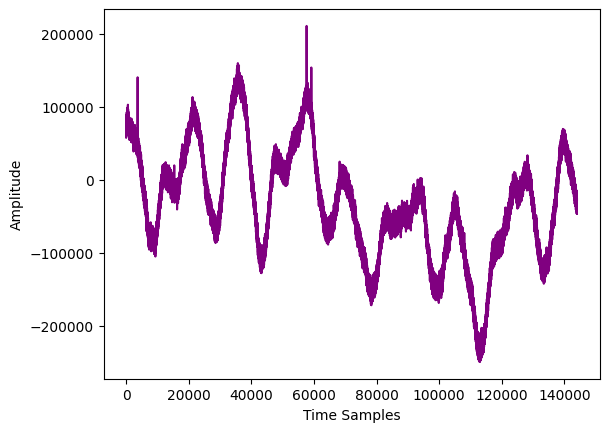

In [8]:
det_num = 1759

plt.figure()
plt.plot(tod.data[det_num,:].T, color = 'purple')
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")
plt.show()

# 1. Time domain cuts

The type of cuts that we will consider is cutting a subsection of the timestreams, usually around some glitches / spikes. These cuts are often referred to as "partial cuts" or "glitch cuts" in ACT, and were implemented as part of TOD pre-processing for ACT DR6. For example, there can be cosmic-ray induced glitches or vibration or anything werid going on in the array. We find these type of cuts using a filtering algorithm. Take the timestream above as an example.

 We can filter through our timestream to find this type of cuts using the `get_glitch_cuts` function. What `get_glitch_cuts` does under the hood is a combination of a Gaussian filter and a high pass filter. Gaussian filter is used to locate peaks and the high pass filter is to get rid of low frequency drifts that are uninteresting for the purpose of finding spikes. In particular, the `tGlitch` parameter specifies the width of the gaussian filter (in seconds) that we want to apply. `highPassFc` specifies the highpass frequency threshold. After filtering, we then look for signals above a certain signal to noise ratio, as specified in the `nSig` parameter. The `buffer` parameter says that, every time we find a glitch, in addition to cut the glitch, we also cut 200 more samples on each side of it, just in case the data near a glitch is unreliable. Most of these parameters are inherited from a long time ago and do not need to change often.



In [9]:
#load the official ACT detector cuts for this TOD
tod.cuts = TODCuts.read_from_path("{}/{}.cuts".format(dir, tod_name))

tod.cuts.nsamps = tod.nsamps
dets = tod.cuts.get_uncut()

In [10]:
glitch_param ={'nSig': 10., 'tGlitch' : 0.007, 'minSeparation': 30,
               'maxGlitch': 50000, 'highPassFc': 6.0, 'buffer': 200}

partial_cuts = get_glitch_cuts(tod=tod, dets = dets, params=glitch_param)


Starting glitch detection pipeline...
Processing 700 detectors with 144000 samples each
Filter creation took 0.03 seconds

Starting vectorized glitch detection...

Detrending data...
Detrending took 0.40 seconds

Performing FFT operations...
FFT operations took 7.60 seconds

Calculating thresholds...
Thresholding took 4.64 seconds

Processing masks...
Mask processing took 2.34 seconds

Creating cuts object...

Total glitch detection pipeline completed in 16.65 seconds


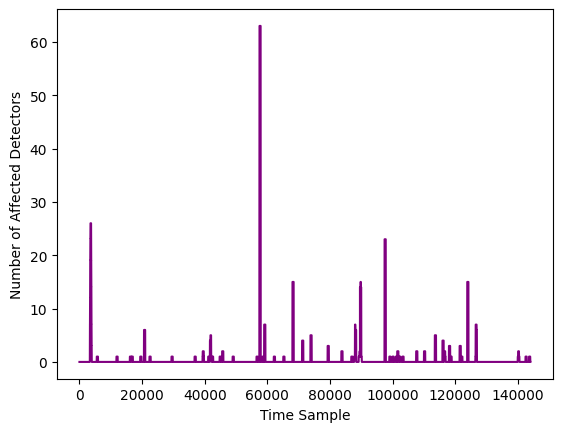

In [11]:
#let's look at how many detectors are flagged at each time step
plt.figure()
n_affected = np.sum([partial_cuts.cuts[i].get_mask() for i in dets], axis=0)
plt.plot(n_affected, color = 'purple')
plt.xlabel('Time Sample')
plt.ylabel('Number of Affected Detectors')
plt.show()

In [12]:
#create cuts vector which says what times more than 4 detectors have been flagged with a glitch
cv = CutsVector.from_mask(n_affected >= 4)

cv_detnum = cv2slices(partial_cuts.cuts[det_num])

print(cv_detnum)

[slice(3481, 3890, None), slice(57453, 57854, None), slice(58962, 59363, None)]


We can see that our glitch finder manages to identify 3 glitches. We can take a closer view of what these glitches are by plotting the samples near these sample ranges.

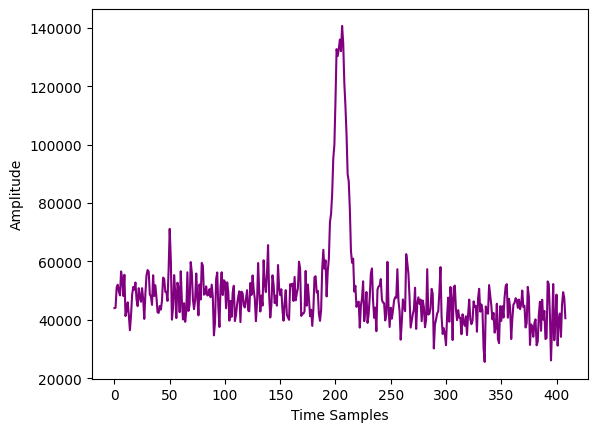

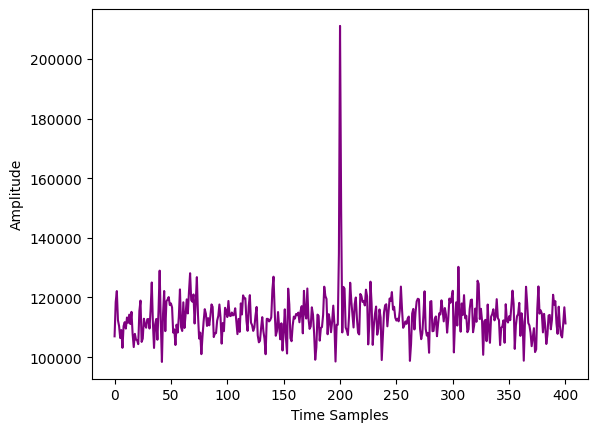

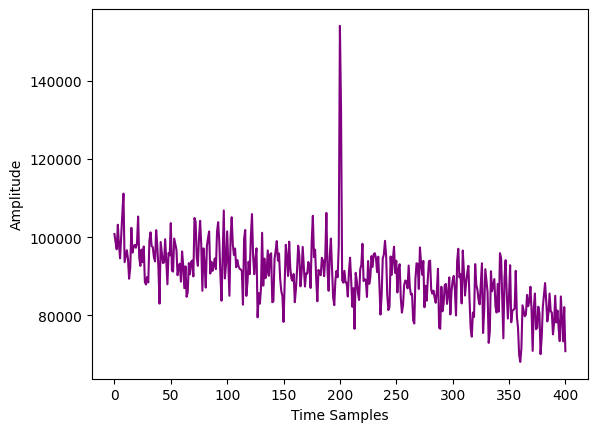

In [13]:
for i in range(len(cv_detnum)):

  plt.figure()
  plt.plot(tod.data[det_num,cv_detnum[i].start : cv_detnum[i].stop].T, color = 'purple')
  plt.xlabel("Time Samples")
  plt.ylabel("Amplitude")
  plt.show()

We can remove the glitch and replace it with a straight line and white noise, with the linear fit and RMS taken from a "neighborhood" of samples on either side of the cut region.  The white noise can be modulated by the filterScaling argument, or turned off entirely by passing no_noise=True.

In [14]:
fill_cuts(tod = tod, cuts = partial_cuts)

Now if we plot the same range of time samples we can see that the spike is gone -- we have successfully got rid of some junk in our data!

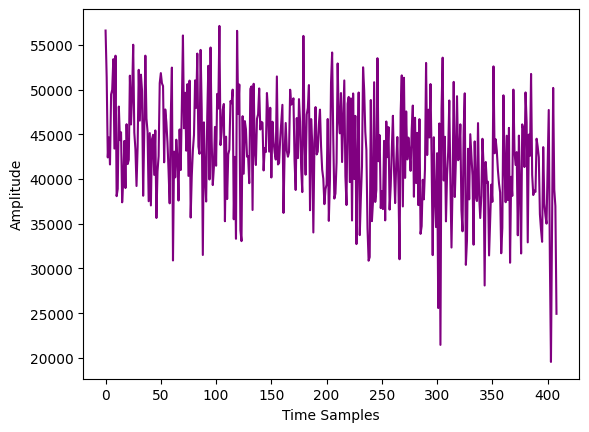

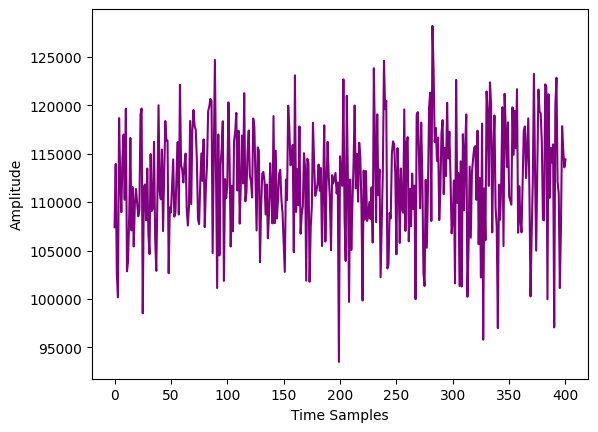

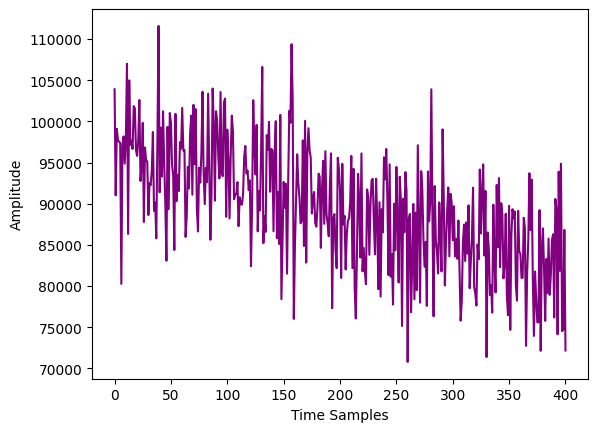

In [15]:
for i in range(len(cv_detnum)):

  plt.figure()
  plt.plot(tod.data[det_num,cv_detnum[i].start : cv_detnum[i].stop].T, color = 'purple')
  plt.xlabel("Time Samples")
  plt.ylabel("Amplitude")
  plt.show()

# 2. Generating Snippets

Since each physical event that triggers glitches in a TOD may affect multiple detectors at slightly different times, we group together glitches that occur in different detectors within 200 time samples of each other  (ACT has a sampling rate ranging from 300 - 400 Hz depending on the detector array). For example, if glitch 1 and glitch 2 occur within 200 samples of each other, and glitch 3 and glitch 2 occur within 200 samples of each other but glitch 1 does not, all three glitches are grouped together. We extract the samples from the impacted detectors within this joint interval and call that subset of the timestream a *snippet*. Snippets thus group together samples from multiple detectors that are potentially affected by the same physical event, and can be analyzed to reveal the spatial and temporal structure of that physical event.

In [16]:
#reload the TOD and cuts as we no longer want the glitches removed
tod = TOD.from_npz(dir, tod_name)
tod.cuts = TODCuts.read_from_path("{}/{}.cuts".format(dir, tod_name))
tod.cuts.nsamps = tod.nsamps
dets = tod.cuts.get_uncut()

In [17]:
#generate glitch cuts and add to tod object
tod.pcuts = get_glitch_cuts(tod=tod, dets=dets, params={'buffer': 200})


Starting glitch detection pipeline...
Processing 700 detectors with 144000 samples each
Filter creation took 0.00 seconds

Starting vectorized glitch detection...

Detrending data...
Detrending took 0.38 seconds

Performing FFT operations...
FFT operations took 7.37 seconds

Calculating thresholds...
Thresholding took 4.50 seconds

Processing masks...
Mask processing took 0.12 seconds

Creating cuts object...

Total glitch detection pipeline completed in 13.46 seconds


In [18]:
#make the cuts vector again
cv = CutsVector.from_mask(n_affected >= 4)
det_mask = np.zeros(tod.data.shape[0], dtype=bool)
det_mask[dets] = 1

Make snippets of glitches which groups together samples from multiple detectors that are potentially affected by the same physical event based on when the glitch is flagged, and can be analyzed to reveal the spatial and temporal structure of that physical event.

In [19]:
snippets = affected_snippets_from_cv(tod, tod.pcuts, cv, det_mask)

Let's look at the snippets for this TOD!

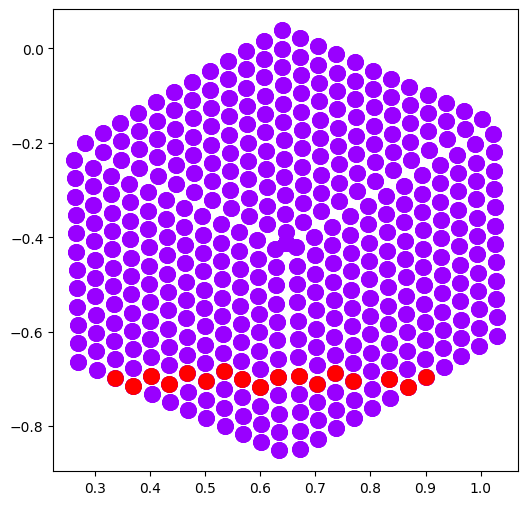

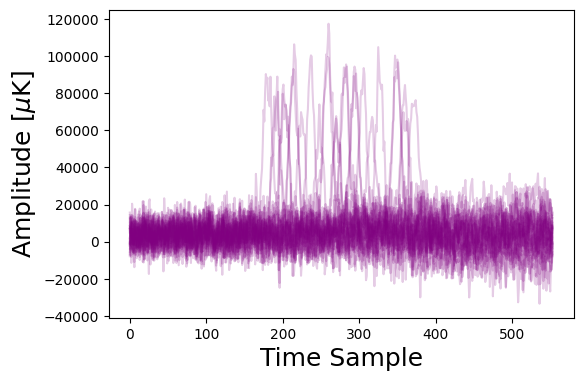

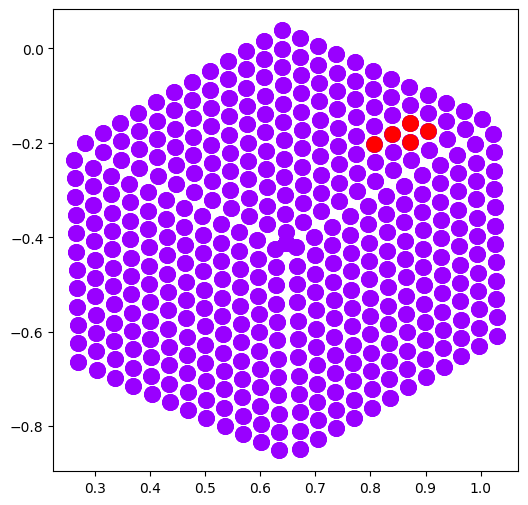

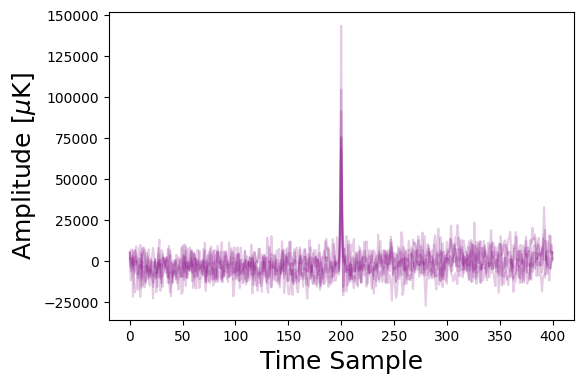

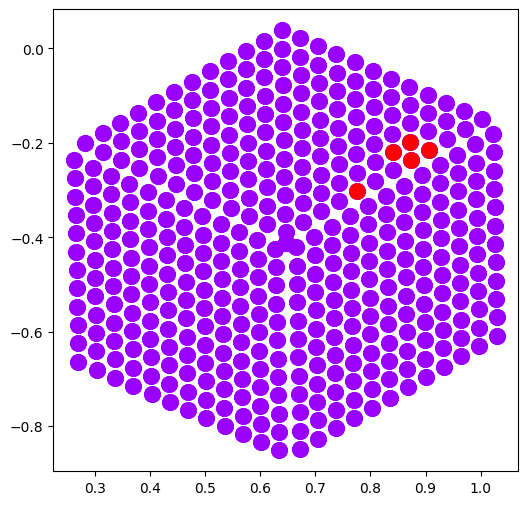

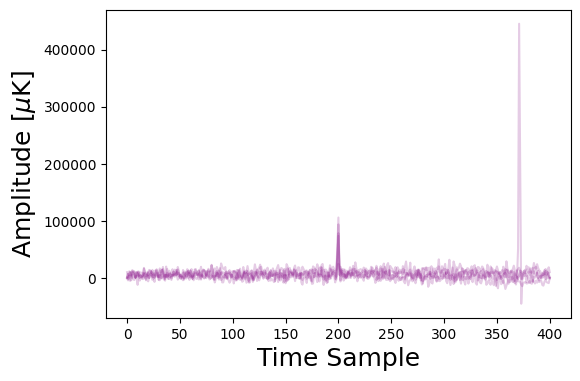

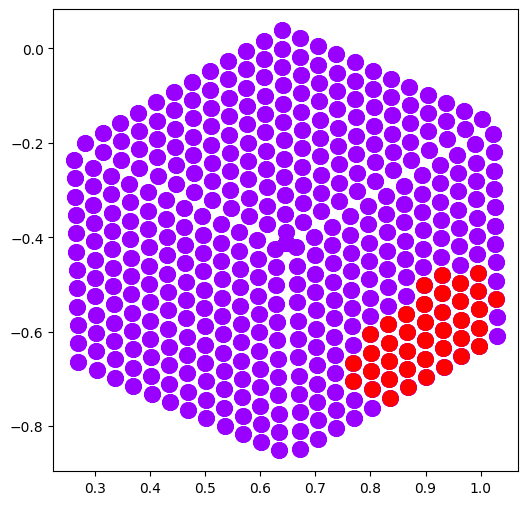

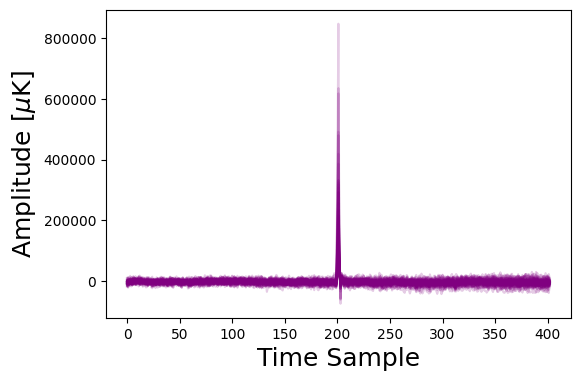

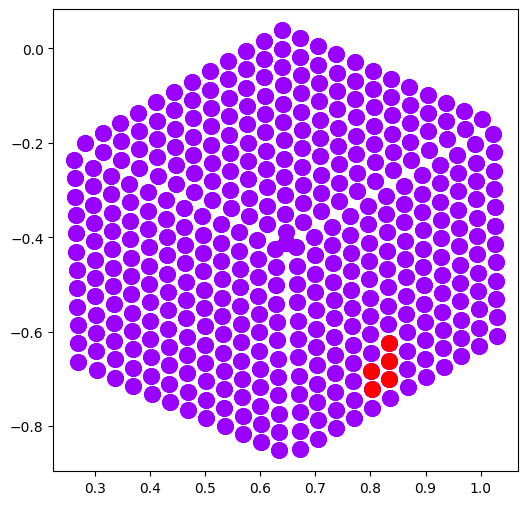

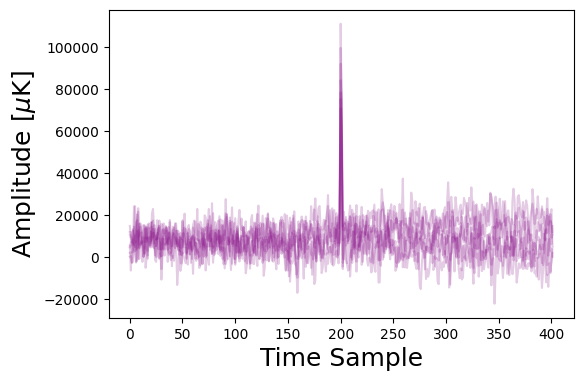

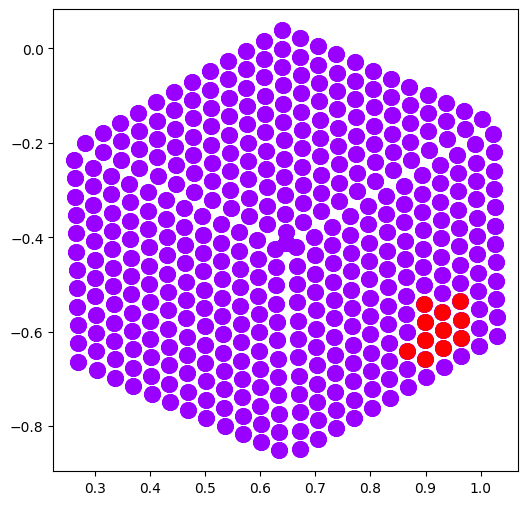

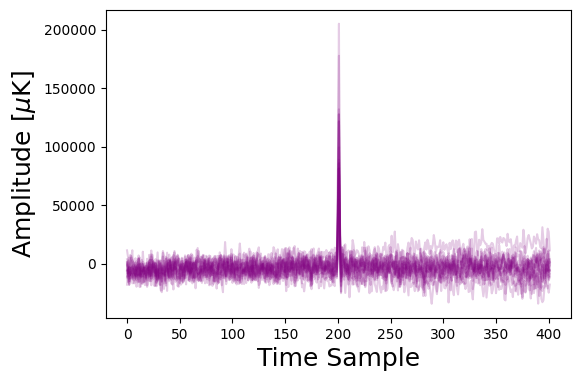

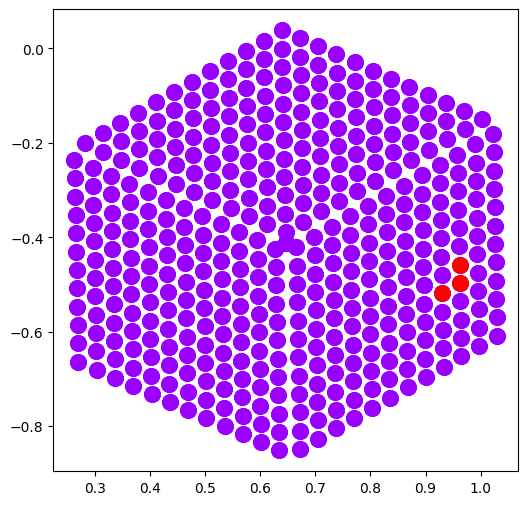

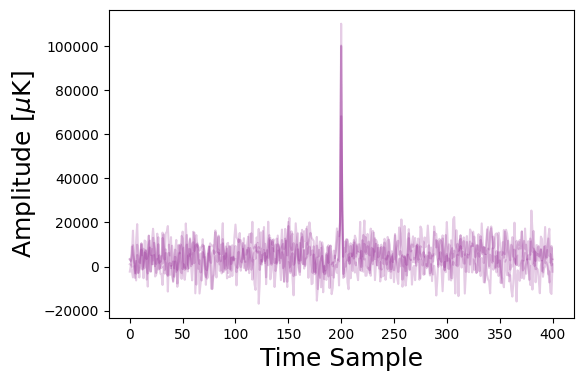

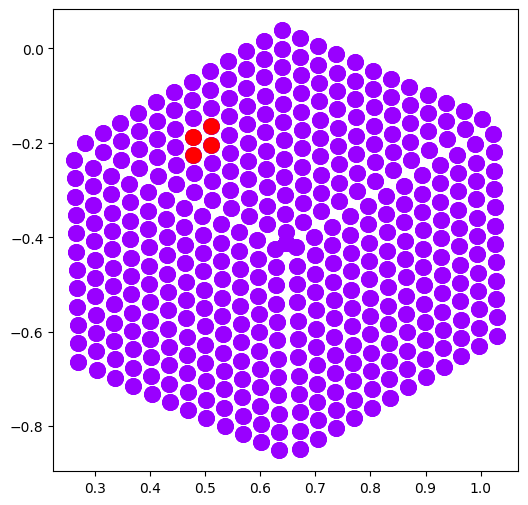

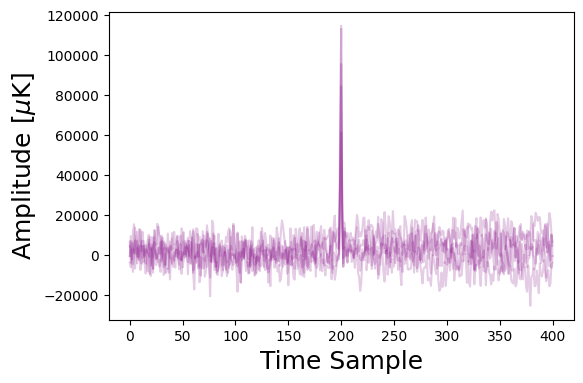

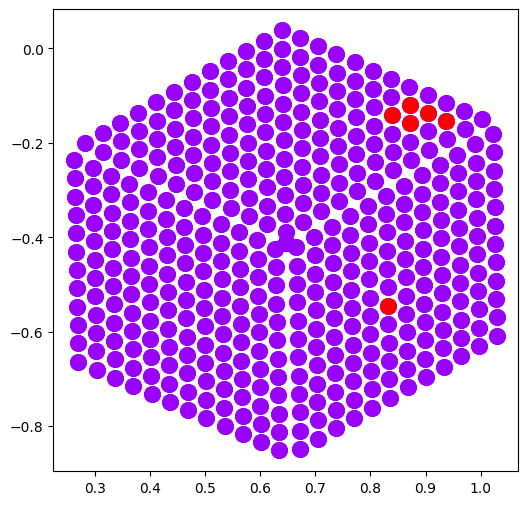

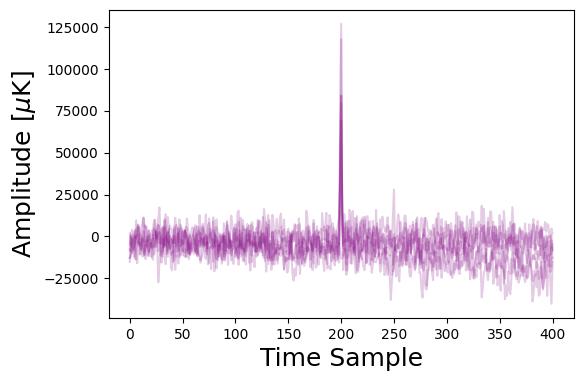

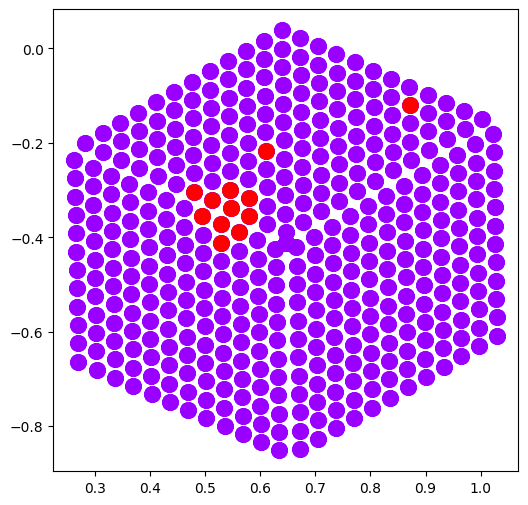

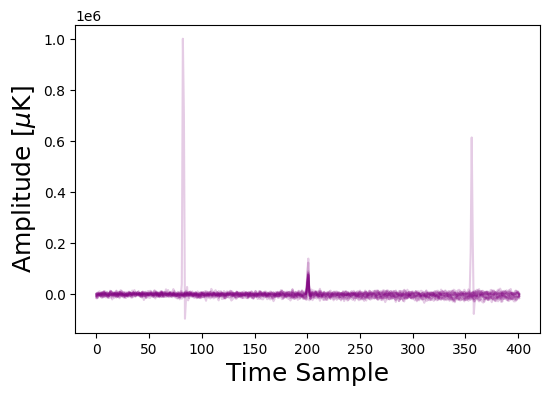

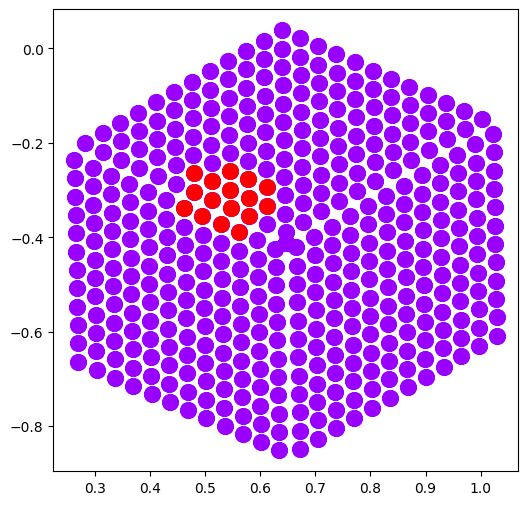

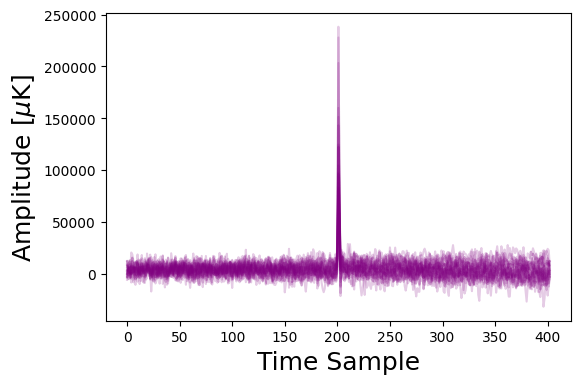

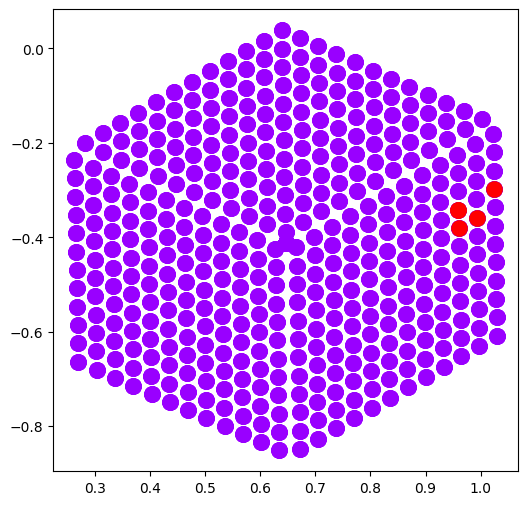

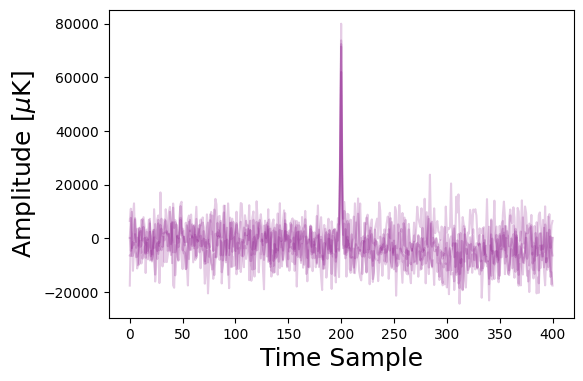

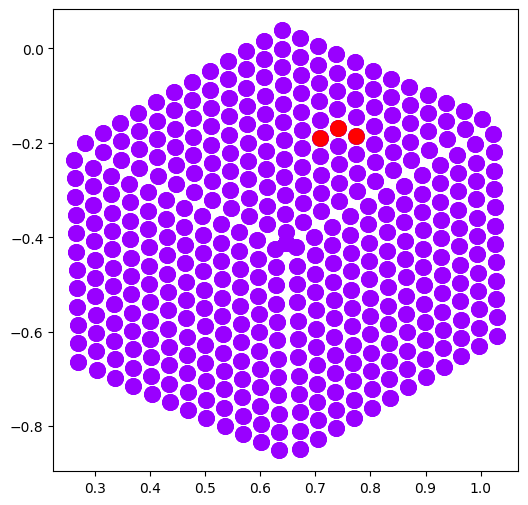

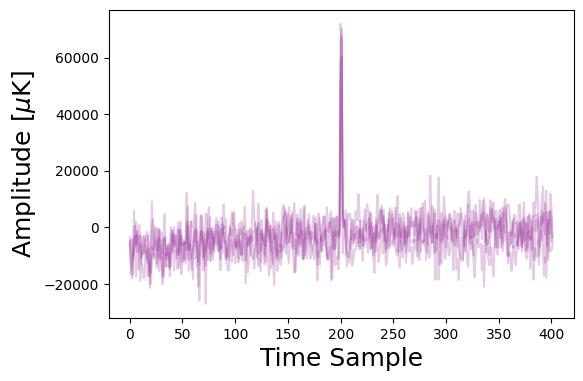

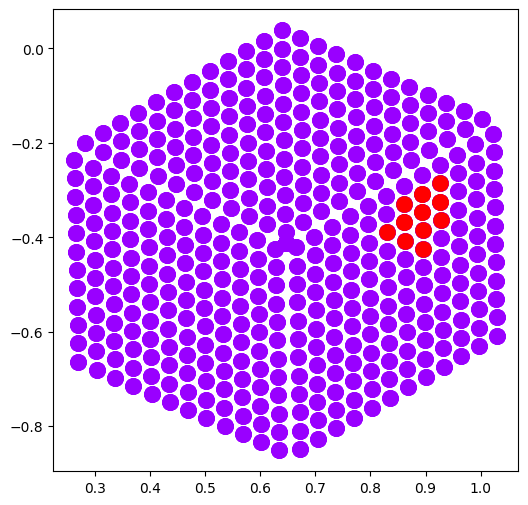

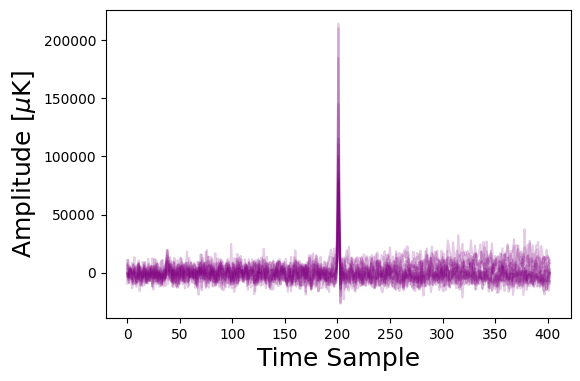

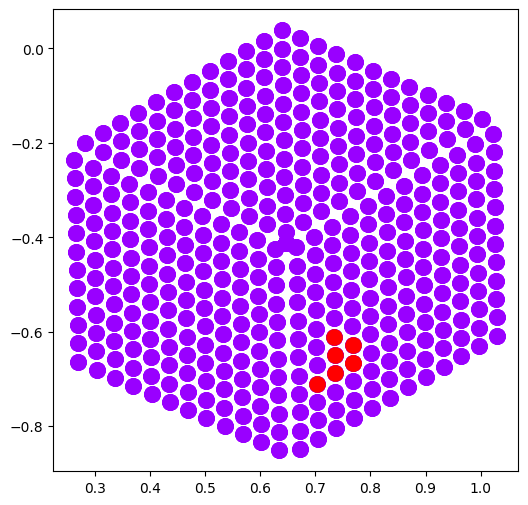

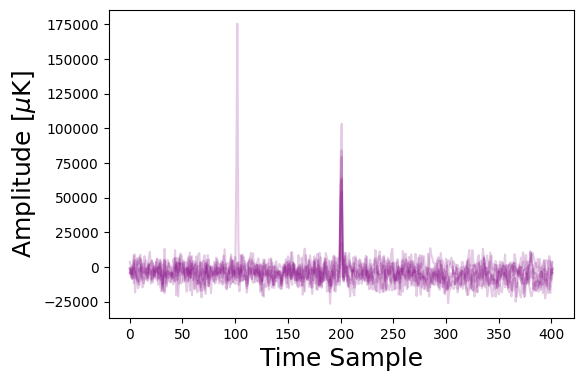

In [20]:
for i in range(len(snippets)):
  mplt.array_plot(snippets[i])
  mplt.tod_plot(snippets[i])

# 3. Computing Summary Statistics and Classifying Glitches

In order to differentiate the glitches produced by the current ACT glitch finder, we extract seven summary statistics per snippet from the timeseries and detector positions as features for the random forest, which can be further grouped into five distinct subtypes:

  * the number of detectors affected by the glitch *Number of Detectors* ;
  * summaries of the distribution of these detectors across the focal plane *Y and X Extent Ratio*, *Normalized Y Maximum*, and *Normalized Y Maximum Within 0.1 $^{\circ}$* ;
  * the correlation of the signal *Correlation* ;
  * the time lag between detectors *Time-lag* ;
  * and the number of peaks in the TODs *Number of Peaks*.

To learn about these stats see [Nerval, Hornecker, and Guan et al. (2025)](https://arxiv.org/abs/2503.10798).

Note: The following work was developed using ACT DR4 and DR6 data, but will be implemented alongside the glitch cuts in upcoming experiments such as SO.

In [21]:
#columns for the data frame we will make
cols = ['Number of Detectors', 'Y and X Extent Ratio', 'Mean abs(Correlation)',
        'Mean abs(Time Lag)', 'Y Hist Max and Adjacent/Number of Detectors',
        'Within 0.1 of Y Hist Max/Number of Detectors', 'Number of Peaks',
        'TOD', 'Start Index', 'Stop Index', 'Start Ctime', 'Stop Ctime']

In [22]:
info = np.empty(shape = (len(snippets), 12))

for s in range(len(snippets)):

  s_t = snippets[s].demean()
  s_t = s_t.deslope()

  data = s_t.data

  slice_inds = snippets[s].tslice

  tstart, tstop = tod.ctime[[slice_inds.start, slice_inds.stop - 1]]

  x_t = snippets[s].info.array_data['sky_x'][snippets[s].det_uid]
  y_t = snippets[s].info.array_data['sky_y'][snippets[s].det_uid]

  det_num = stat.num_of_det(x_t)

  hist_ratio = stat.x_and_y_histogram_extent_ratio(x_t, y_t)

  time_lag = stat.mean_time_lags(data)

  corr = stat.mean_correlation(data)

  near = stat.max_and_near_y_pos_ratio(y_t)

  adjacent = stat.max_and_adjacent_y_pos_ratio(y_t)

  num_peaks = stat.compute_num_peaks(data)

  info[s, 0] = det_num
  info[s, 1] = hist_ratio
  info[s, 2] = corr
  info[s, 3] = time_lag
  info[s, 4] = adjacent
  info[s, 5] = near
  info[s, 6] = num_peaks
  info[s, 7] = 5
  info[s, 8] = slice_inds.start
  info[s, 9] = slice_inds.stop
  info[s, 10] = tstart
  info[s, 11] = tstop

df = pd.DataFrame(np.asarray(info), columns = cols)

df['Glitch'] = 'Unlabelled'


df['TOD'] = tod_name

In [23]:
#read in training set with labels

df_train = pd.read_csv('{}/oct092024_trainingset_for_colab.csv'.format(dir))

In [24]:
#stats we will use as our features for the classifictaion
stats = ['Number of Detectors', 'Y and X Extent Ratio','Y Hist Max and Adjacent/Number of Detectors',
          'Within 0.1 of Y Hist Max/Number of Detectors', 'Mean abs(Correlation)', 'Mean abs(Time Lag)',
            'Number of Peaks']

In [25]:
X, Y = df_train[stats], df_train['Train_Lab']

#specifying the hyperparameters
n_trees = 50 #number of decision trees
max_depth = 15 #the maximum number of times each decision tree is allowed to split

We use a random forest machine learning algorithm, which can be thought of as a collection of ``decision trees'' that classify data based on the input features which are the stats we computed above. Feel free to try other supervised learning algorithms! You can find all the ones offered by scikit-learn [here](https://scikit-learn.org/stable/supervised_learning.html).

In [26]:
forest = RandomForestClassifier(criterion='entropy',n_estimators=n_trees,random_state=1,n_jobs=2, oob_score = True, max_depth = max_depth)
forest.fit(X, Y)

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=50,
                       n_jobs=2, oob_score=True, random_state=1)

Here is an example function for classifying the glitches with the trained forest, you can try different models and modify the function accordingly.

In [27]:
def classify_data_forest(df_classify, cols, trained_forest):

    '''
    Classify glitches using a random forest.

    Input: df_classify: panadas data frame of data to classify,
    cols: list of columns of stats to use for classification (must match cols used for training),
    trained_forest: trained random forest
    Output: df_w_labs_and_stats: returns the dataframe with a column for the predicted labels - int from
    0 - 3 corresponding to 0: Point Source, 1: Point Source + Another Glitch 2: Cosmic Ray, 3: Electronic Glitch also columns
    with the probability that the glitch is each of the categories
    '''

    col_predictions = ['Glitch Prediction', 'Probability of being a Point Source', 'Probability of being a Point Source + Another Glicth',
                       'Probability of being a Cosmic Ray', 'Probability of being an Electronic Glitch']

    categories  = ['Point Source', 'Point Source + Another Glitch', 'Cosmic Ray', 'Electronic Glitch']

    X_classify = df_classify[cols]

    y_pred_forest = trained_forest.predict(X_classify)

    y_pred_forest_probs = trained_forest.predict_proba(X_classify)

    predictions = np.zeros((X_classify.shape[0], 5))

    predictions[:, 0] = y_pred_forest
    predictions[:, 1] = y_pred_forest_probs[:, 0]
    predictions[:, 2] = y_pred_forest_probs[:, 1]
    predictions[:, 3] = y_pred_forest_probs[:, 2]
    predictions[:, 4] = y_pred_forest_probs[:, 3]

    lab_df = pd.DataFrame(predictions, columns = col_predictions)

    df_w_labs_and_stats = pd.concat([df_classify, lab_df], axis = 1)

    df_w_labs_and_stats['Glitch'] = df_w_labs_and_stats['Glitch Prediction'].astype(int).apply(lambda x: categories[int(x)])

    return df_w_labs_and_stats

In [28]:
df_classified = classify_data_forest(df, stats, forest)

In [29]:
df_classified['Glitch'].value_counts()

Glitch
Cosmic Ray           13
Point Source          1
Electronic Glitch     1
Name: count, dtype: int64

Let's check if these classifications make sense!

['Point Source']


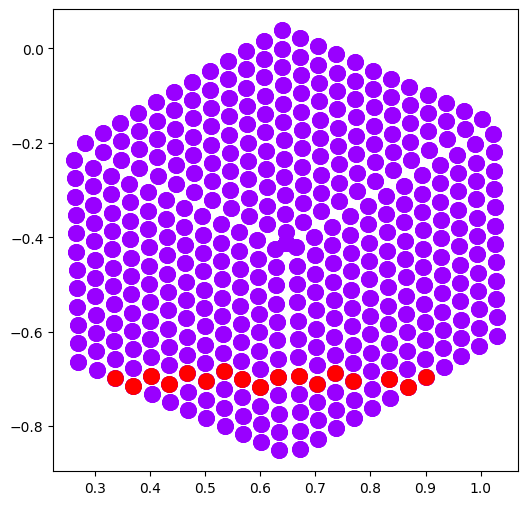

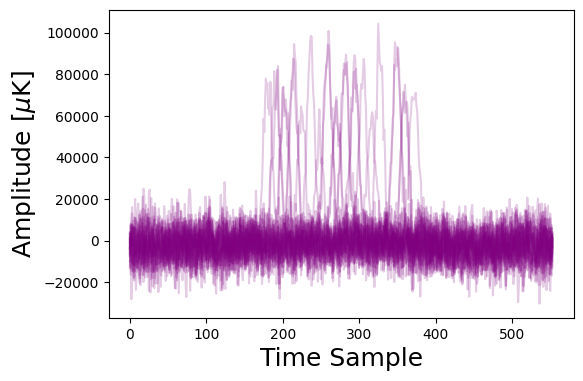

['Cosmic Ray']


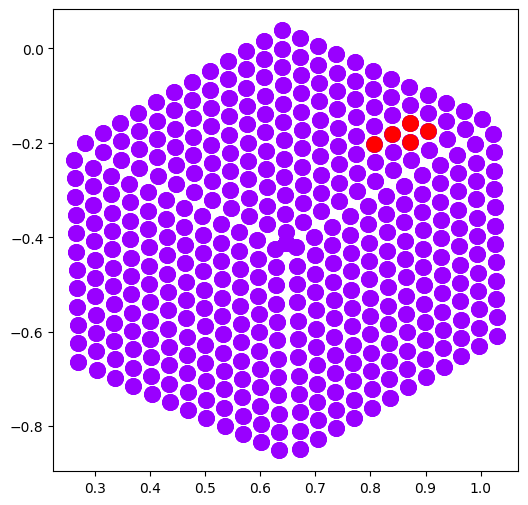

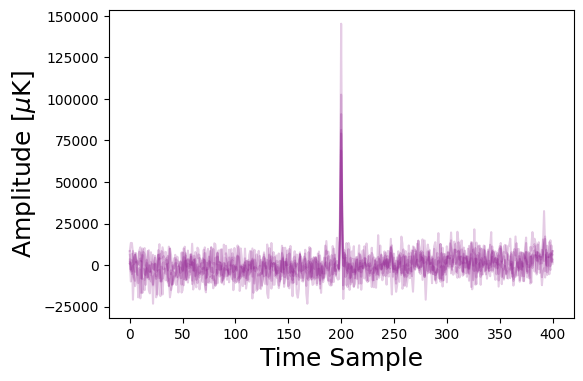

['Electronic Glitch']


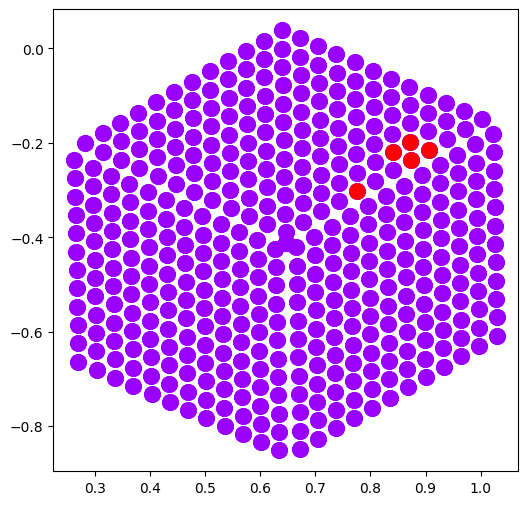

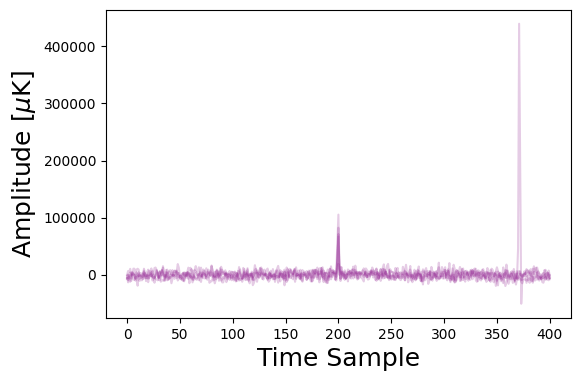

['Cosmic Ray']


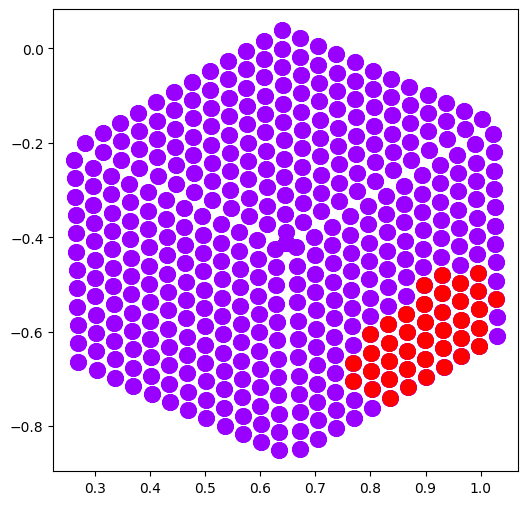

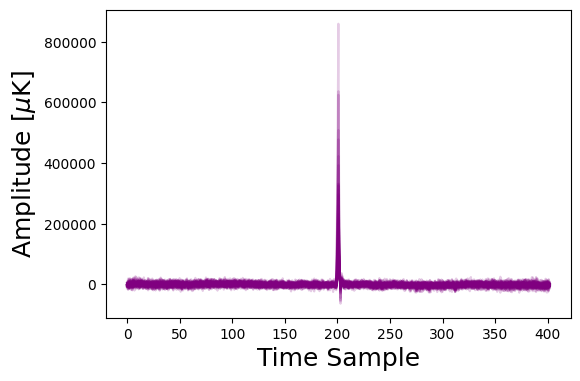

['Cosmic Ray']


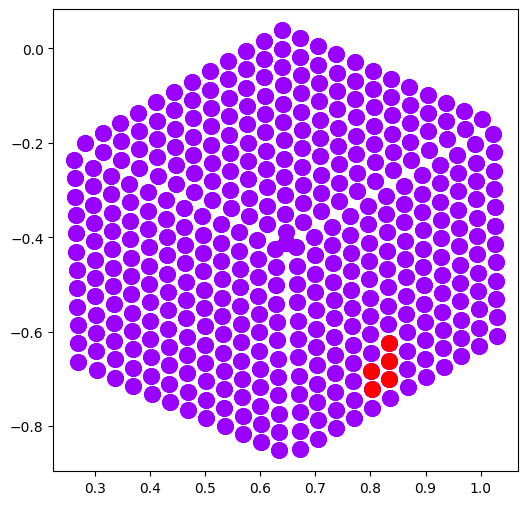

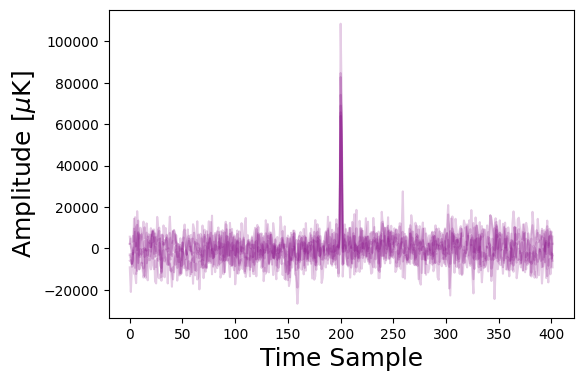

['Cosmic Ray']


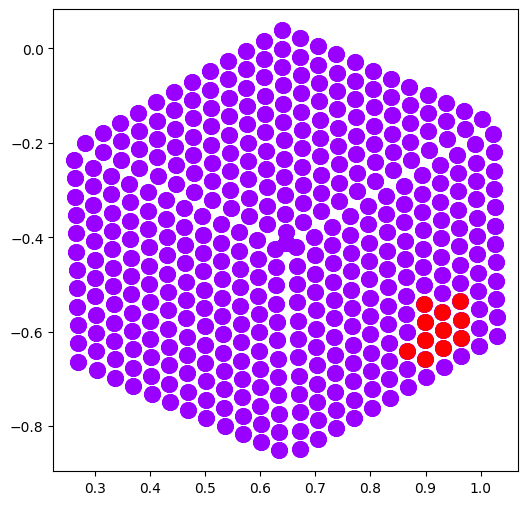

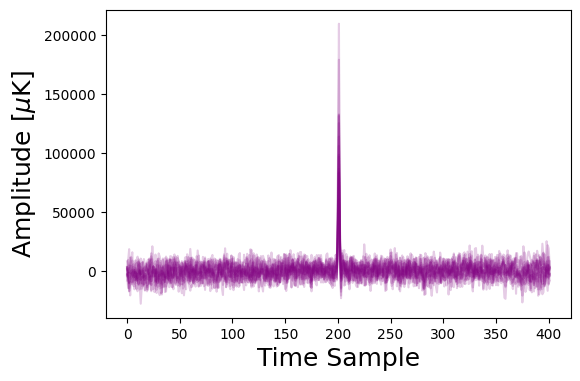

['Cosmic Ray']


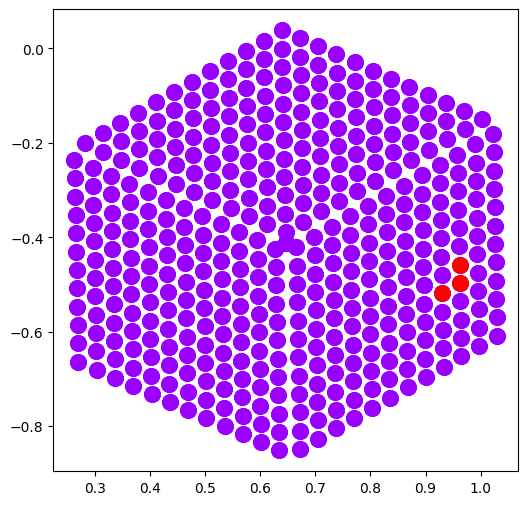

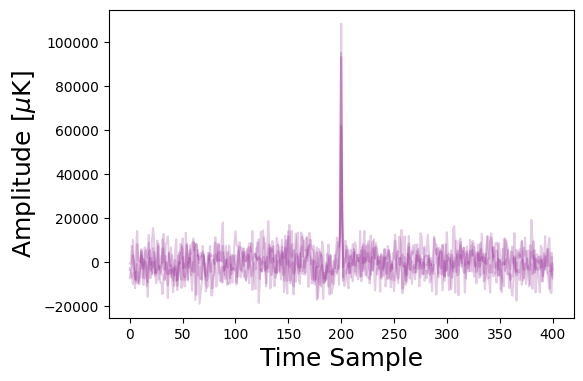

['Cosmic Ray']


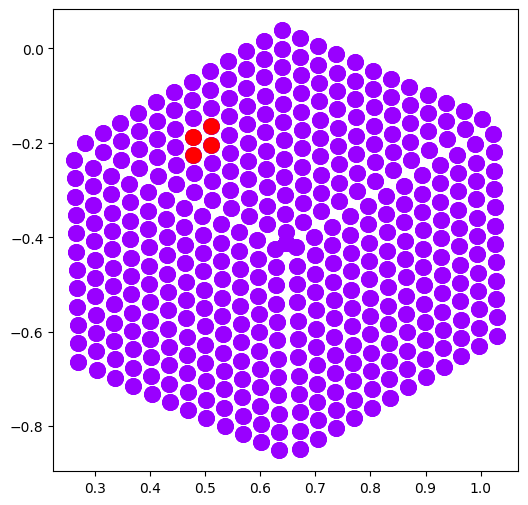

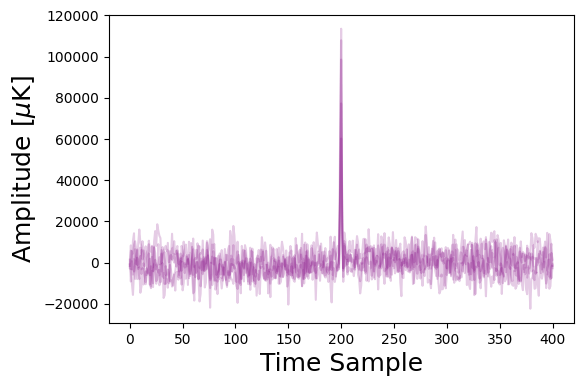

['Cosmic Ray']


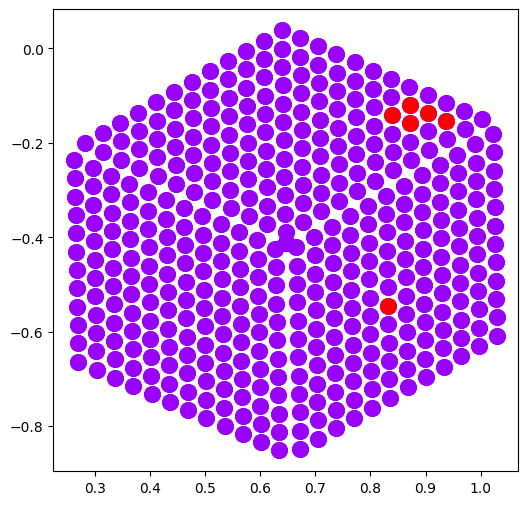

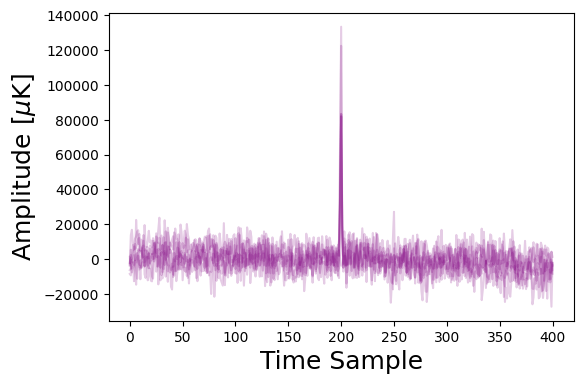

['Cosmic Ray']


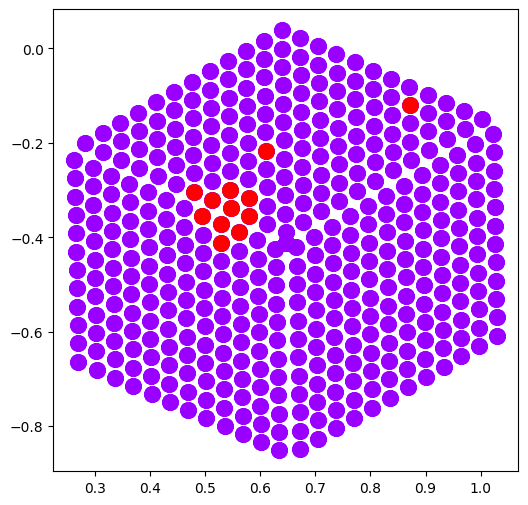

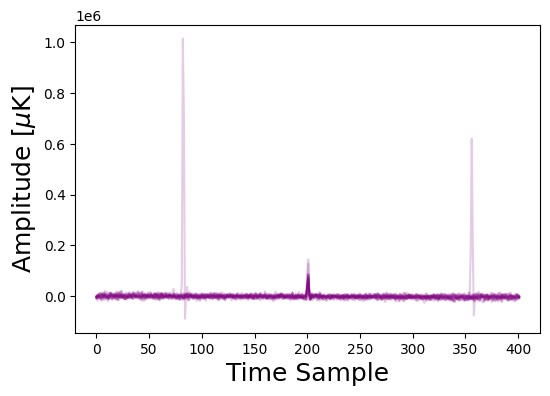

['Cosmic Ray']


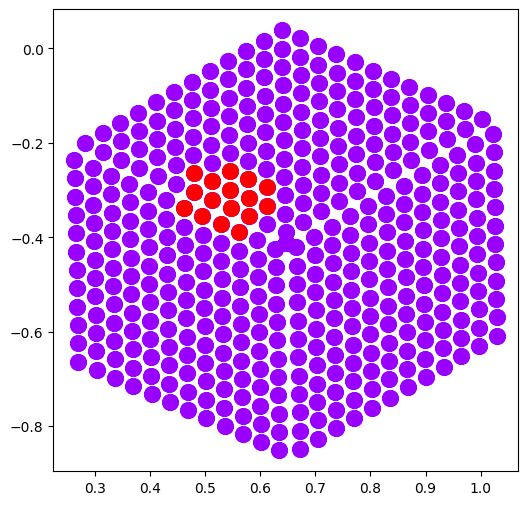

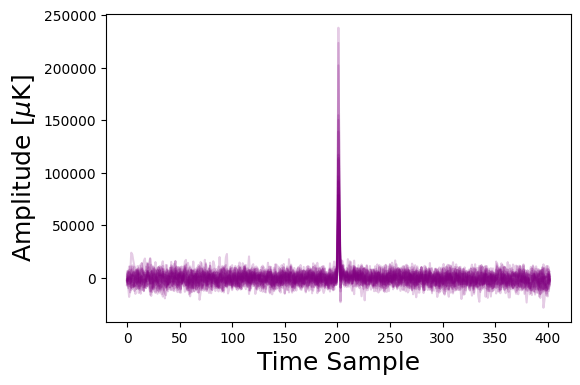

['Cosmic Ray']


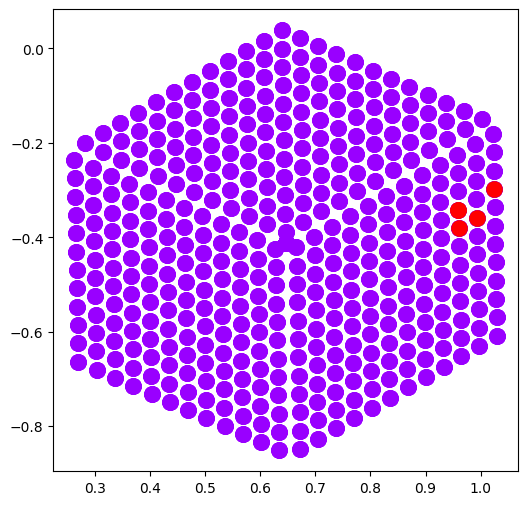

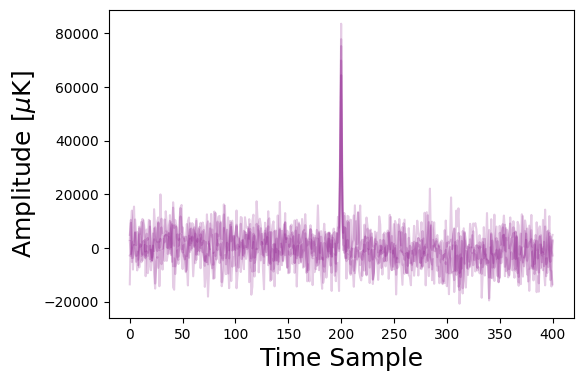

['Cosmic Ray']


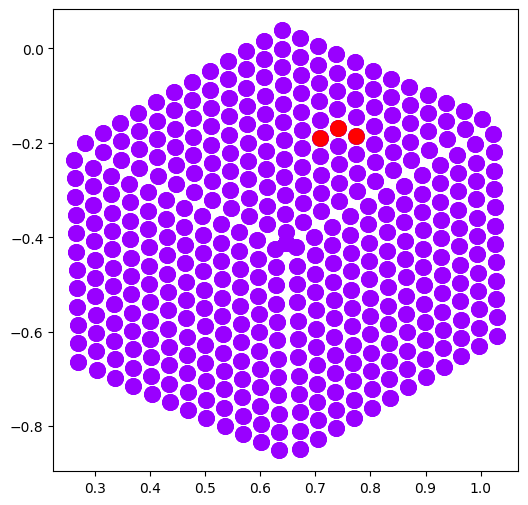

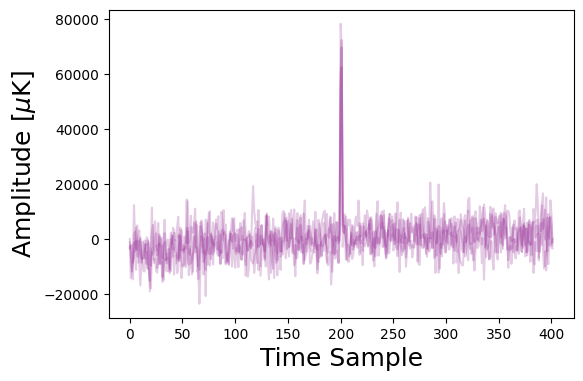

['Cosmic Ray']


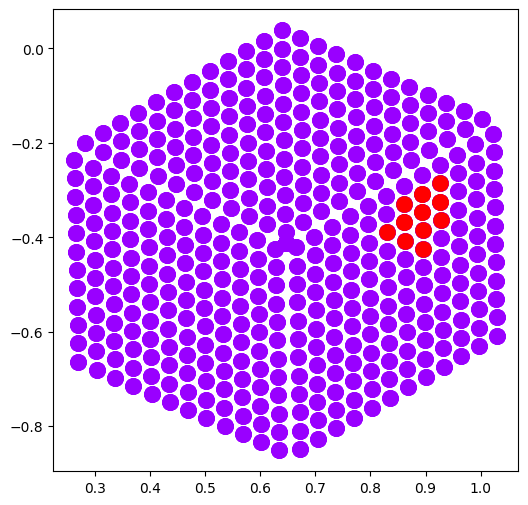

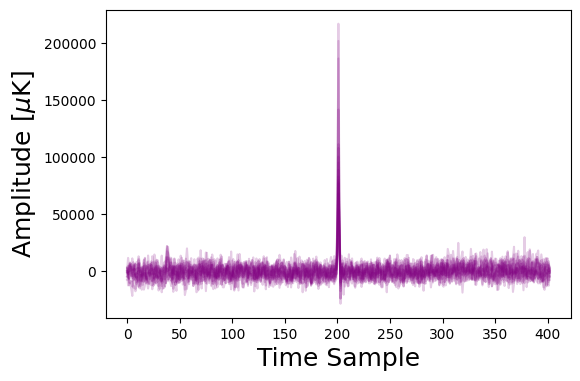

['Cosmic Ray']


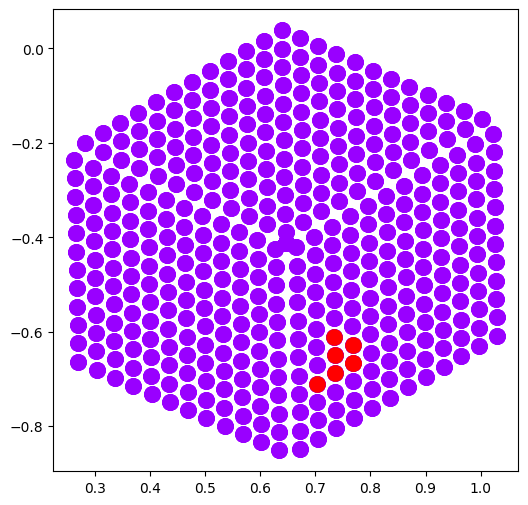

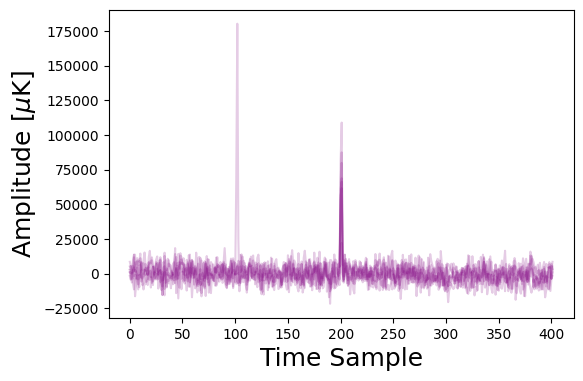

In [30]:
for i in range(len(snippets)):
  print(df_classified.loc[df_classified['Start Index'].astype(int) == snippets[i].tslice.start, 'Glitch'].values)
  mplt.array_plot(snippets[i])
  mplt.tod_plot(snippets[i])

# 4. Stellar Flare Simulations

Now we are going to load a simulated stellar flare and make a light curve!

Let's use a simple model in which an instantaneous jump in flux is followed by an exponential decrease. We vary the amplitude of the injected source over time as:
\begin{equation}
\begin{cases}
    S(t) = 0 &, t < t_0 \\
    S(t) = A_0 \exp[-\frac{\ln(2)}{h}(t-t_0)] &, t \geq t_0,
\end{cases}
\end{equation}
where $A_0$ is the initial amplitude of the flare, $h$ is the half-life of the decaying flare, and $t_0$ is the start time of the flare, which we select to be when the source enters the focal plane for the first time in the TOD.

For more information on how these flares were simulated see [Nerval, Hornecker, and Guan et al. (2025)](https://arxiv.org/abs/2503.10798).

Here we are using a TOD with a simulated flare with a peak amplitude of 12 Jy. The half-life of the flare is can be chosen to be either 500s or 100s.

In [31]:
tod_name_sim = '1566115984.1566125361.ar5_f150'

amp = '12000'
halflife = '500'

Load the TOD and read in the cuts.

In [32]:
tod_sim = TOD.from_npz_sims(dir, tod_name_sim, amp, halflife)
tod_sim.cuts = TODCuts.read_from_path("{}/{}.cuts".format(dir, tod_name_sim))
tod_sim.cuts.nsamps = tod_sim.nsamps

In [33]:
#the sims only get the detectors that weren't cut, so we will use all of them
dets_sim = tod_sim.det_uid
tod_sim.pcuts = get_glitch_cuts(tod=tod_sim, dets=dets_sim, params={'buffer': 200})
det_mask_sim = np.zeros(tod_sim.data.shape[0], dtype=bool)
det_mask_sim[dets_sim] = 1


Starting glitch detection pipeline...
Processing 707 detectors with 144000 samples each
Filter creation took 0.01 seconds

Starting vectorized glitch detection...

Detrending data...
Detrending took 0.30 seconds

Performing FFT operations...
FFT operations took 7.59 seconds

Calculating thresholds...
Thresholding took 6.15 seconds

Processing masks...
Mask processing took 0.61 seconds

Creating cuts object...

Total glitch detection pipeline completed in 15.90 seconds


Instead of making a cuts vector, we are going to load a dataframe which contains the snippet timeslices for the source.

In [34]:
df_cv = pd.read_csv('{}/df_sims_{}_amp{}_h{}_naffected_4.csv'.format(dir, tod_name_sim, amp, halflife))

In [35]:
tslices = np.zeros((len(df_cv), 2), dtype = int)

for i in range(len(df_cv)):
  tslices[i] = [int(df_cv['Start Index'][i]), int(df_cv['Stop Index'][i])]

In [36]:
snippets_sim = affected_snippets_from_cv(tod_sim, tod_sim.pcuts, tslices, det_mask_sim)

Let's plot these snippets. Notice how the source moves up the focal plane from snippet to snippet as the sky drifts over time.

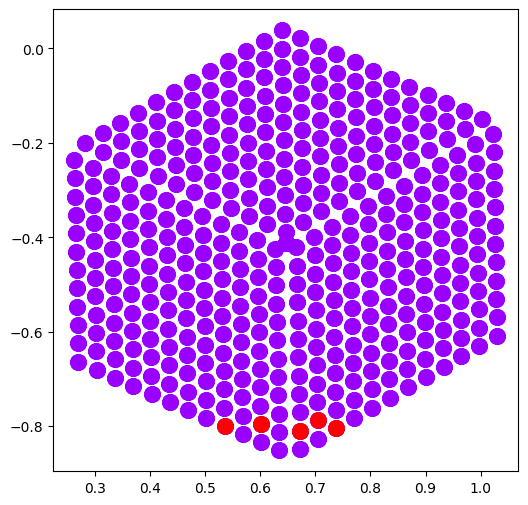

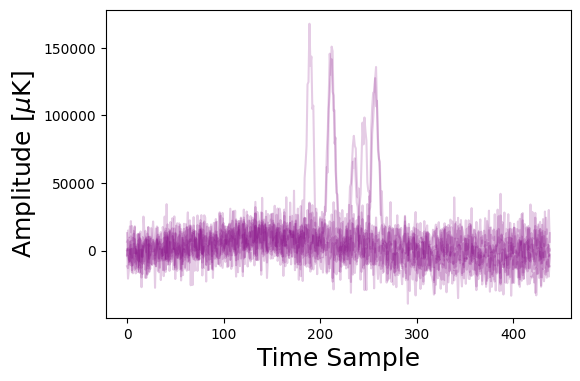

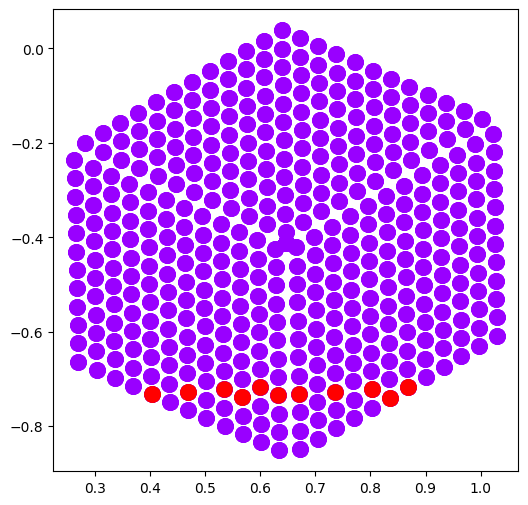

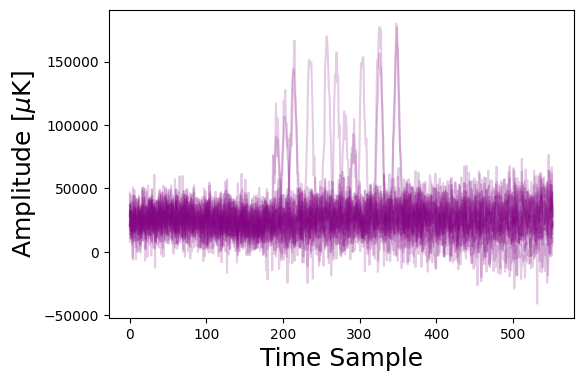

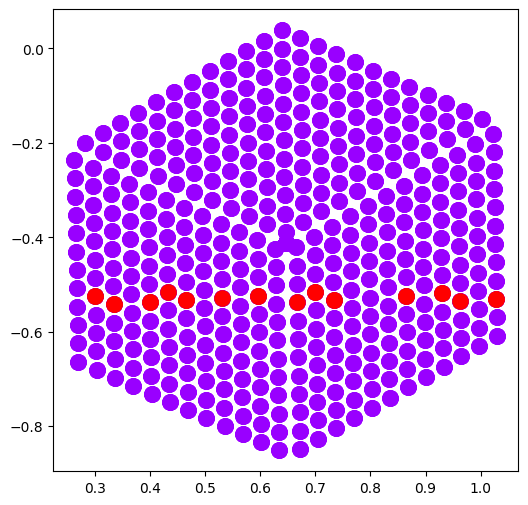

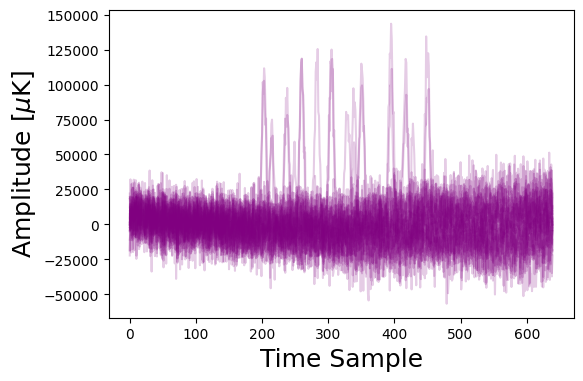

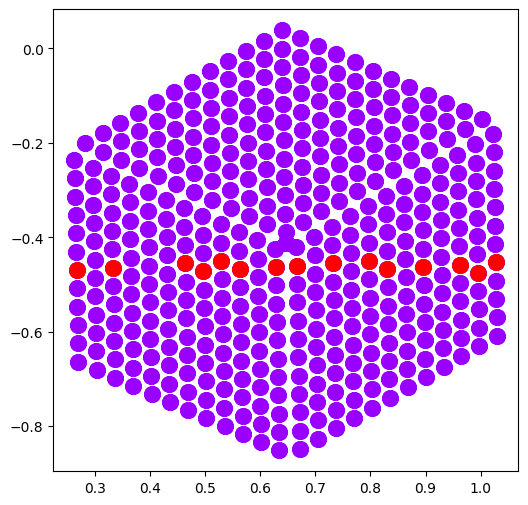

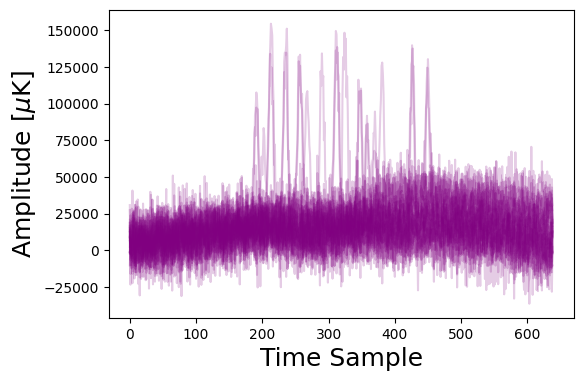

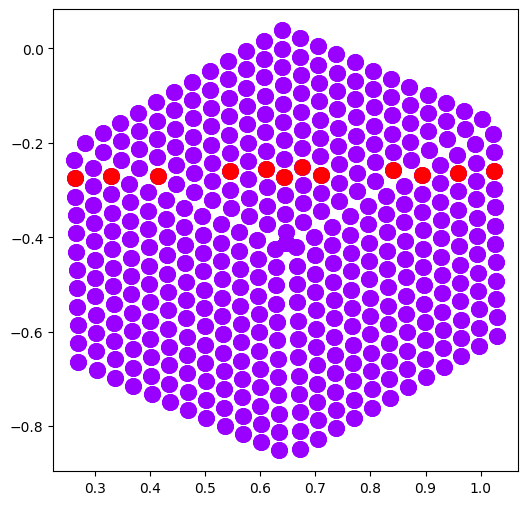

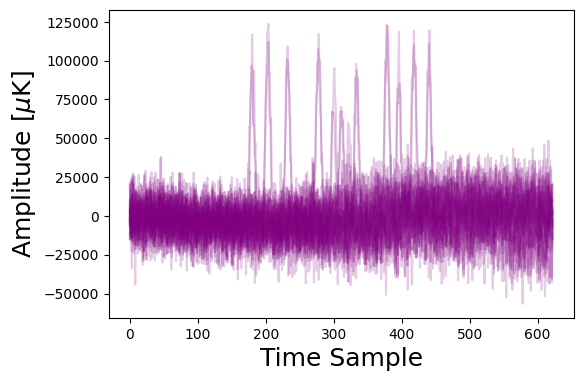

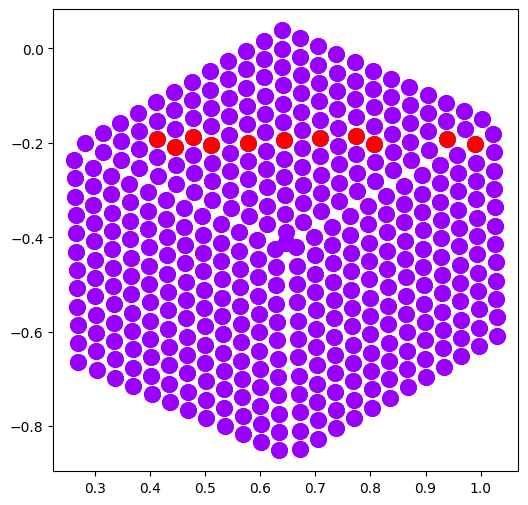

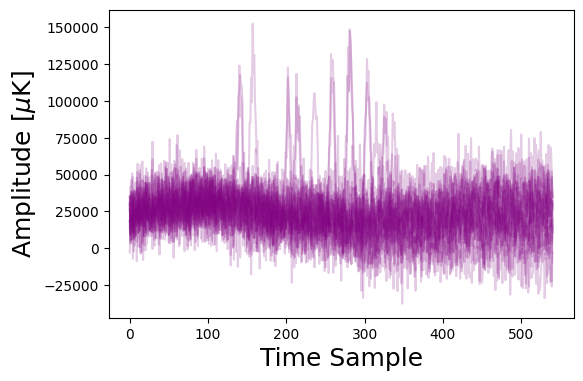

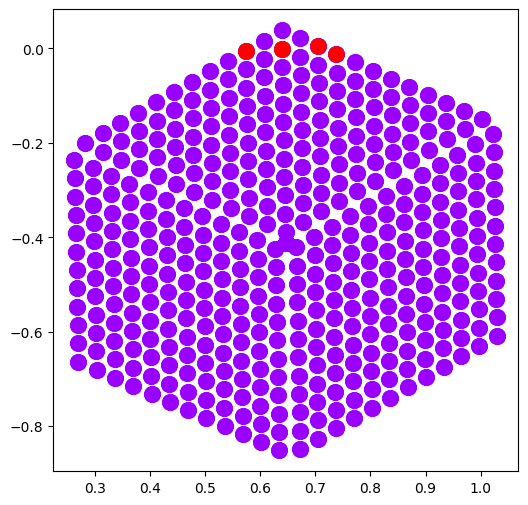

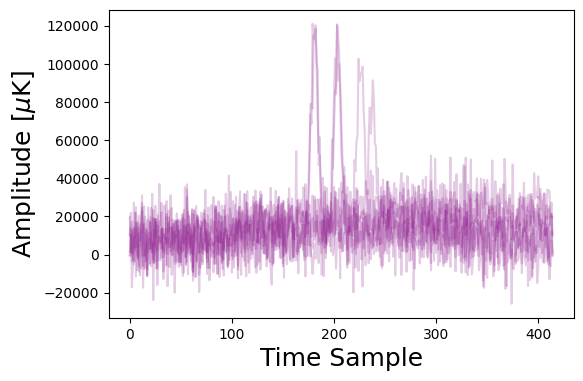

In [37]:
for i in range(len(snippets_sim)):

  mplt.array_plot(snippets_sim[i], sim=True, tod_sim=tod_sim)
  mplt.tod_plot(snippets_sim[i])

Let's make sure these would be classified correctly!

In [38]:
info_sim = np.empty(shape = (len(snippets_sim), 12))

for s in range(len(snippets_sim)):

  s_t = snippets_sim[s].demean()
  s_t = s_t.deslope()

  data = s_t.data

  slice_inds = snippets_sim[s].tslice

  tstart, tstop = tod_sim.ctime[[slice_inds.start, slice_inds.stop - 1]]

  x_t = snippets_sim[s].info.array_data['sky_x'][np.asarray(tod_sim.det_uid_original)[snippets_sim[s].det_uid]]
  y_t = snippets_sim[s].info.array_data['sky_y'][np.asarray(tod_sim.det_uid_original)[snippets_sim[s].det_uid]]

  det_num = stat.num_of_det(x_t)

  hist_ratio = stat.x_and_y_histogram_extent_ratio(x_t, y_t)

  time_lag = stat.mean_time_lags(data)

  corr = stat.mean_correlation(data)

  near = stat.max_and_near_y_pos_ratio(y_t)

  adjacent = stat.max_and_adjacent_y_pos_ratio(y_t)

  num_peaks = stat.compute_num_peaks(data)

  info_sim[s, 0] = det_num
  info_sim[s, 1] = hist_ratio
  info_sim[s, 2] = corr
  info_sim[s, 3] = time_lag
  info_sim[s, 4] = adjacent
  info_sim[s, 5] = near
  info_sim[s, 6] = num_peaks
  info_sim[s, 7] = 5
  info_sim[s, 8] = slice_inds.start
  info_sim[s, 9] = slice_inds.stop
  info_sim[s, 10] = tstart
  info_sim[s, 11] = tstop

df_sim = pd.DataFrame(np.asarray(info_sim), columns = cols)


df_sim['TOD'] = tod_name_sim

In [39]:
df_classified_sim = classify_data_forest(df_sim, stats, forest)

In [40]:
df_classified_sim['Glitch'].value_counts()

Glitch
Point Source    7
Name: count, dtype: int64

# 5. Amplitude computation

One of the benefits of the classification algorithm is its ability to detect signals from astrophysical sources that were not previously in our catalogue, like different types of transients!

If a source is observed multiple times, as the focal plane scans back and forth in azimuth at constant elevation, we can measure changes in the amplitude of the source on scales of less than a minute for an ACT-like experiment. This has important implications for transient science, where some sources, like flaring stars, can vary on time scales of minutes or seconds, whereas other sources, such as extragalactic transients like GRBs, TDEs and SNs, vary on much longer time scales of days or more.

In this section we will make a light curve for the simluated stellar flare.

Let's begin by just looking at one snippet of the flare, and finding the amplitude. Before computing the amplitude we further isolate the signal of the source in the TOD by creating a copy of the snippet with the peaks excised, then subtracting this copy from the original snippet. This removes any remaining large-scale drift across the length of the snippet.

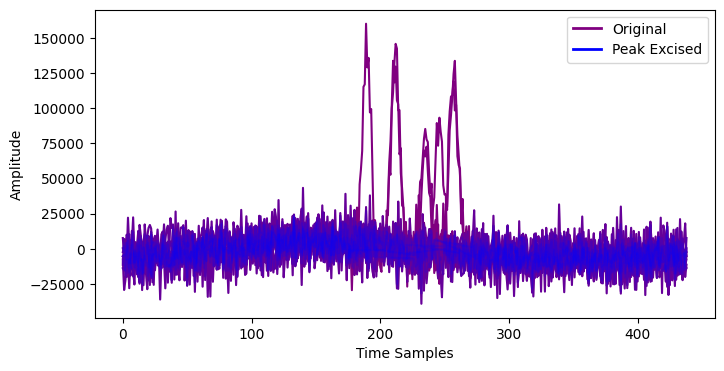

In [41]:
snip_idx = 0
snip = snippets_sim[snip_idx]
slice_inds = snip.tslice
snip_data = snip.data
excised = amp_func.excise_peaks(snip.data, 15)

plt.figure(figsize=(8,4))
plt.plot(snip.data.T, color='purple')
plt.plot(excised.T, color='blue', alpha=0.2)
plt.plot(np.empty(1), np.empty(1), lw = 2, color = 'purple', label = 'Original')
plt.plot(np.empty(1), np.empty(1), lw = 2, color = 'blue', label = 'Peak Excised')
plt.xlabel('Time Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

The snippet we end up using looks like this, now we mostly just have the source signal


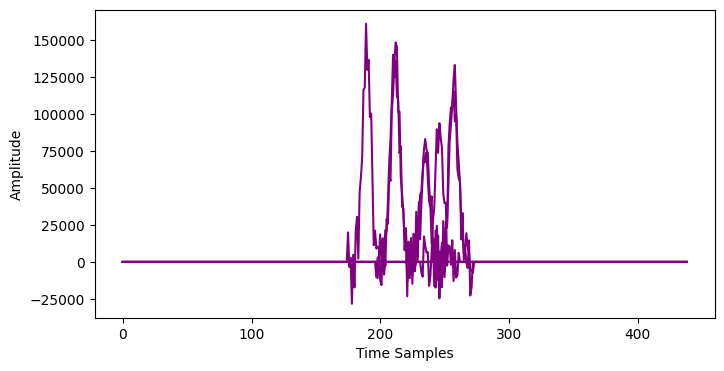

In [42]:
snip_data = snip.data - excised

plt.figure(figsize=(8,4))
plt.plot(snip_data.T, color='purple')
plt.xlabel('Time Samples')
plt.ylabel('Amplitude')
plt.show()

The data we end up using look like this: we concatenate the observations from each detector, there are 8 peaks here because there are 8 detectors that see the source


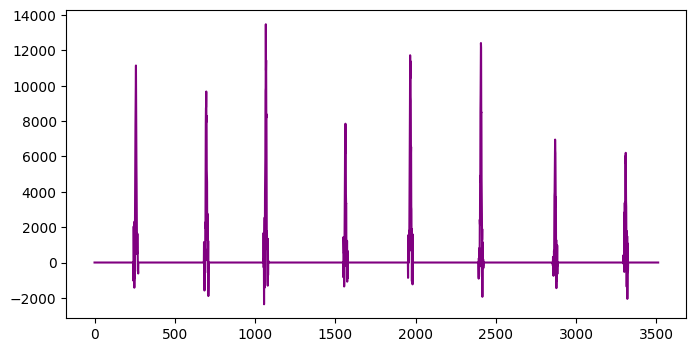

In [43]:
d_final = snip_data.flatten()
d_final = amp_func.calibrate(d_final)

plt.figure(figsize=(8,4))
plt.plot(d_final, color='purple')
plt.show()


We model the amplitude of a source in our timestreams with a non-linear least-squares fit to the following model
\begin{equation}
    A({\theta}_{\mathrm{det}}) = A_0 B(|{\theta}_{\mathrm{det}}-{\theta}_{\mathrm{src}}|) + C,
\end{equation}
where $A$ is the amplitude measured by a detector observing the sky at right ascension/declination position ${\theta}_{\mathrm{det}}$, $A_0$ is the intrinsic amplitude of the source located at position ${\theta}_{\mathrm{src}}$, $B(\theta)$ is the azimuthally-averaged, normalized beam profile of the telescope, and $C$ is an offset to account for the baseline of the signal being nonzero. The independent variable in the fit is ${\theta}_{\mathrm{det}}$ and the fit parameters are $A_0$, ${\theta}_{\mathrm{src}}$ and $C$.


So we need the detector pointings! Normally we can get those in the TOD metadata, but here we will load them from a file.

In [44]:
pos_csv = 'pos_{}_amp{}_h{}_tstart_{}_tend_{}.csv'.format(tod_name_sim, amp, halflife, slice_inds.start, slice_inds.stop)
pos_df = pd.read_csv('{}/{}'.format(dir, pos_csv))

pos_df.ra *= 180/np.pi
pos_df.dec *= 180/np.pi

Let's get the guess parameters for the fit (amplitude, ra, dec, offset).

In [45]:
n_dets = len(snip_data)
n_samps = len(snip_data[0])

#save 3D array with det = [N_dets, N_samps, RA/DEC]
det = np.zeros((n_dets,n_samps,2))

for j in range (n_dets):

  pos_df_t = pos_df.loc[pos_df['det_id'] == np.asarray(tod_sim.det_uid_original)[snip.det_uid[j]]]
  ras = pos_df_t['ra'].values
  decs = pos_df_t['dec'].values

  for n in range(n_samps):
    det[j][n][0] = ras[n]
    det[j][n][1] = decs[n]

det_final = det.reshape(-1, det.shape[-1])
guess_amp = np.amax(d_final)

# For the guess ra/dec we simply take the mean ra/dec of the snippet
guess_ra = np.mean(pos_df['ra'].values)
guess_dec = np.mean(pos_df['dec'].values)

guess_off = np.mean(snip_data[:100])

Let's look at our initial guesses for the fit... they're quite close for a simulated stellar flare that peaks at 12Jy at
ra = 79.0230 and dec = -29.3602

In [46]:
print(f'Guess amplitude: {guess_amp:6.1f} mJy')
print(f'Guess ra: {guess_ra:6.3f} deg')
print(f'Guess dec: {guess_dec:6.3f} deg')

Guess amplitude: 13480.5 mJy
Guess ra: 79.036 deg
Guess dec: -29.363 deg


Now let's fit to our model...

In [47]:
popt, pcov = curve_fit(amp_func.amp_fit, det_final, d_final, p0=[guess_amp, guess_ra, guess_dec, guess_off])

fit_amp =  popt[0]
fit_ra = popt[1]
fit_dec = popt[2]
fit_off = popt[3]

Using these best fit parameters we recover the profile of the source in the TOD as seen below (note again that the arrays have been flattened)


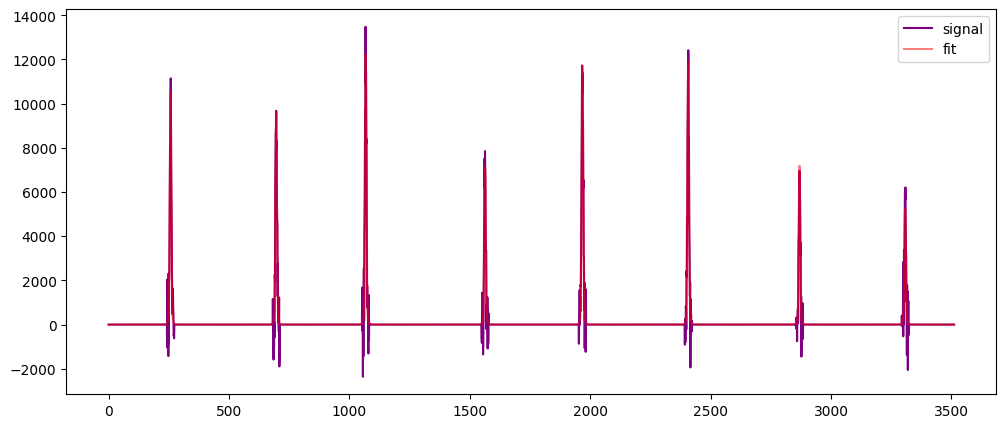

In [48]:
fit = amp_func.amp_fit(det_final, fit_amp, fit_ra, fit_dec, fit_off)
plt.figure(figsize=(12,5))
plt.plot(d_final, color='purple', label = 'signal')
plt.plot(fit, color='red', alpha=0.5, label = 'fit')
plt.legend()
plt.show()


If we zoom into the peaks...

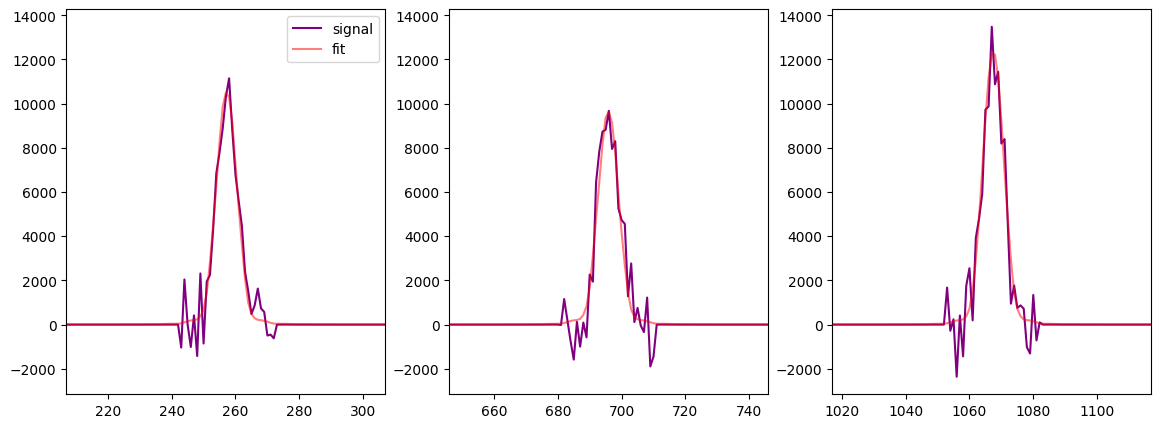

In [49]:
peak_idx = sp.signal.find_peaks(fit, prominence=fit_amp/3)[0]

plt.figure(figsize=(14,5))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.plot(d_final, color='purple', label = 'signal')
ax1.plot(fit, color='red', alpha=0.5, label='fit')
ax1.set_xlim(peak_idx[0]-50, peak_idx[0]+50)
ax1.legend()

ax2.plot(d_final, color='purple')
ax2.plot(fit, color='red', alpha=0.5)
ax2.set_xlim(peak_idx[1]-50, peak_idx[1]+50)

ax3.plot(d_final, color='purple')
ax3.plot(fit, color='red', alpha=0.5)
ax3.set_xlim(peak_idx[2]-50, peak_idx[2]+50)

plt.show()

We can do this for all the snippets from the stellar flare and make a light curve.


In [50]:
amps, times_flare = amp_func.get_all_amps(tod_name_sim, tod_sim, snippets_sim, amp, halflife, dir)

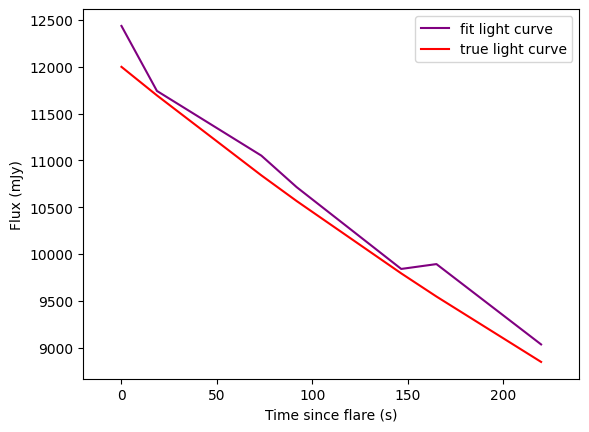

In [51]:
t0 = times_flare[0]
times_flare = times_flare - t0
times = tod_sim.ctime

plt.plot(times_flare, amps, label ='fit light curve', color = 'purple')
plt.plot(times_flare, amp_func.flare(times_flare, 12000, int(halflife)), label = 'true light curve', color = 'red')
plt.xlim(times_flare[0]-20, times_flare[-1]+20)
plt.xlabel('Time since flare (s)')
plt.ylabel('Flux (mJy)')
plt.legend()
plt.show()